In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import models, transforms, datasets
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix ,precision_score, recall_score
from PIL import Image
import numpy as np
import cv2
import os
import random
import requests
from pathlib import Path
import zipfile
from PIL import Image, ImageDraw
from pathlib import Path
import seaborn as sns
import shutil
from bs4 import BeautifulSoup
import time

# 1.Statement Problem

## 1.1 Problem and Pain point


<p>ทุเรียนเป็นหนึ่งในพืชผลทางการเกษตรที่มีความสำคัญกับประเทศไทยเป็นอย่างมาก แต่ในการปลูกทุเรียนนั้นจะพบปัญหามากมายที่ส่งผลต่อผลผลิตหรือการออกผลของทุเรียน และปัญหาที่สำคัญที่สุดคือการระบาดของโรคทางใบของทุเรียนอันเนื่องมาจากเชื้อรา</p>

<p>เชื้อราที่ระบาดในทุเรียนนั้นมีหลากหลายชนิด ได้แก่ โรคใบจุด โรคใบจุดสาหร่ายหรือใบจุดสนิม และโรคใบไหม้ โรคแต่ละโรคจะมีลักษณะแตกต่างกันแต่จะสร้างความเสียหายให้ใบทุเรียนแบบเดียวกันนั่นคือการเกาะอาศัยบนใบของทุเรียนและแย่งสารอาหารเพื่อใช้ในการเจริญเติบโตและลดพื้นที่สีเขียวซึ่งใช้ในการสังเคราะห์แสงเพื่อสร้างอาหารของต้นทุเรียน หากการระบาดเกิดขึ้นทั่วทั้งทรงพุ่มของต้นทุเรียนในท้ายที่สุดก็อาจจะทำให้ต้นทุเรียนตายได้</p>

<p>เพื่อป้องกันปัญหาดังกล่าว หากพบเห็นการระบาดตั้งแต่ต้นจำเป็นต้องจัดการให้เร็วที่สุดเพื่อป้องกันการระบาดของโรคทั่วทั้งทรงพุ่ม โดยโรคทางใบแต่ละโรคที่ระบาดจำเป็นต้องใช้วิธีการที่ถูกต้องเพื่อป้องกันการระบาดได้อย่างมีประสิทธิภาพ การจำแนกโรคจึงถือเป็นเรื่องที่สำคัญมาก ต้องอาศัยประสบการณ์และความชำนาญ แม้กระทั่งชาวสวนทุเรียนเองยังมีโอกาสจำแนกได้ผิดพลาด โดยเฉพาะโรคใบจุด กับโรคใบจุดสาหร่ายซึ่งมีความคล้ายคลึงกันมาก</p>

<p>ทางคณะผู้จัดทำจึงมีความคิดที่จะพัฒนา “หมอทุเรียน” Line Chat Bot ที่สามารถจำแนกโรคทางใบของทุเรียนได้อย่างสะดวกและแม่นยำผ่านกระบวนการ Image Processing ร่วมกับเทคโนโลยีปัญญาประดิษฐ์ โดยโมเดลที่ใช้ในการจำแนกโรคทางใบของทุเรียนคือโมเดล Convolutional Neural Network (CNN) และใช้เทคนิค Transfer Learning จากโมเดล Efficientnet B0 และ Adam optimizer และมีการทำ Binary Classification ด้วยโมเดล Convolutional Neural Network (CNN) และใช้เทคนิค Transfer Learning จากโมเดล Efficientnet B0</p>


## 1.2 Related work
จากการศึกษางานวิจัย Durian Disease Classification Using Transfer Learning For Disease Management System (Marizuana ,2023)จะพบว่าโมเดล ResNet-9 สามารถตรวจจับโรคใบทุเรียนได้อย่างถูกต้องถึง 99.1% เมื่อใช้เทคนิค Adam optimizer 

จากผลลัพธ์ของงานวิจัยที่ศึกษจะพบว่าสามารถวิเคราะห์ว่าเป็นใบทุเรียนได้อย่างถูกต้อง แต่หากผู้คนที่นำ Model ตัวนี้ไปใช้วิเคราะห์สิ่งของอื่นๆที่ไม่ใช่ใบทุเรียนอาจเกิดข้อผิดพลาดในการวิเคราะห์หรือไม่ 

**Reference**
- https://www.researchgate.net/publication/377682437_DURIAN_DISEASE_CLASSIFICATION_USING_TRANSFER_LEARNING_FOR_DISEASE_MANAGEMENT_SYSTEM
- https://openagriculturejournal.com/VOLUME/18/ELOCATOR/e18743315305194/FULLTEXT/
- https://www.semanticscholar.org/paper/Plant-leaf-disease-classification-using-deep-model-Atila-U%C3%A7ar/7a96cf43dc8b99e4da527ec645931a0033effc67
- https://www.sciencedirect.com/science/article/pii/S1574954120301321?casa_token=382NVKnOwRMAAAAA:dNrhoiSe7D8gq39fO5iKrhmPbSRjzPv5lVrf5S-jJPBTV28BXgdArFGq8PudrEhPjPJfinvTLA


## 1.3 Unique method
- ในการสร้าง Model ครั้งนี้ใช้ dataset ทั้งหมด 1402 ภาพ โดยใบทุเรียนที่ใช้ใน dataset จะเป็นใบทุเรียนพันธุ์หมอนทอง ซึ่งผู้จัดทำได้ลงพื้นที่เพื่อเก็บข้อมูลสวนทุเรียนเจ๊โอ๊ะ อ.วังจันทร์ จ.ระยอง
- จากงานวิจัยข้างต้นเกี่ยวกับการวิเคราะห์โรคทางใบทุเรียนจะมีการใช้การเรียนรู้แบบ Transfer Learning โดยใช้ Model ResNet-9 และ VGG-19 ซึ่งทางผู้จัดทำได้ใช้ วิธีการ Transfer Learning เช่นเดียวกับงานวิจัยแต่ได้ลองเปลี่ยนModelเป็น Efficient Net ซึ่งพบว่ามีงานวิจัยที่ใช้ Model ตัวนี้ในการวิเคราะห์โรคทางใบพืชได้ดีกว่าModelตัวอื่นๆ ทางผู้จัดทำจึงลองนำข้อดีของModelตัวนี้มาลองปรับใช้กับการวิเคราะห์โรคทางใบทุเรียน
- ทางผู้จัดทำได้แก้ปัญหาการวิเคราะห์สิ่งของที่ไม่ใช่ใบทุเรียนโดยการทำ Model อีก1ตัวขึ้นมาเพื่อวิเคราะห์ว่าภาพที่ถ่ายเป็นใบทุเรียนหรือไม่ ก่อนที่จะส่งให้ Model วิเคราะห์โรคทางใบทุเรียน

# 2.Data Preparation

## 2.1 Data source
- ข้อมูลภาพของโรคทางใบทุเรียนมาจากการลงพื้นที่เพื่อไปเก็บภาพที่สวนทุเรียนในจังหวัดระยอง
- ลิ้งค์ข้อมูลภาพถ่าย:https://drive.google.com/drive/folders/1gzLkERv8j7eObMGhgltvhjmPMCOAsqtJ
- ลิ้งค์ข้อมูลภาพถ่าย:https://github.com/ThanawatRung/Durian_Ai.git

## 2.2 Data Cleaning
- สำหรับกระบวนการcleaningข้อมูล ทางพวกเราได้ทำการจำแนกภาพของโรคในใบทุเรียนแต่ละชนิดแยกไว้ในแต่ละ Folder ตามที่อยู่ในลิ้งค์เพื่อนำข้อมูลมาทำการแบ่งอัตราส่วนแต่ละโรคให้เป็นข้อมูลที่ใช้ในการ train 70% และ test 30% (การทำดังกล่าวจะช่วยให้ภาพของแต่ละโรคถูกแบ่งในอัตราส่วนที่เท่ากันเนื่องจากแต่ละโรคมีไฟล์ภาพข้อมูลที่ไม่เท่ากัน)

In [29]:
#สร้าง path ข้อมูลสำหรับการเก็บข้อมูลที่จะใช้ในการ train และ test
data_path = Path("data/")
image_path_train = data_path / "train"
image_path_test = data_path / "test"

if image_path_train.is_dir():
  print(f"{image_path_train} directory exists.")
else:
  print(f"Did not find {image_path_train} directory, creating one...")
  image_path_train.mkdir(parents=True, exist_ok=True)

if image_path_test.is_dir():
  print(f"{image_path_test} directory exists.")
else:
  print(f"Did not find {image_path_test} directory, creating one...")
  image_path_test.mkdir(parents=True, exist_ok=True)

data/train directory exists.
data/test directory exists.


In [14]:
#ดึงข้อมูลจากไฟล์ที่อัพไว้บนGithub(เป็นfolderเดียวกันกับในลิ้งค์)
!apt-get install git
!git init
!git remote add origin https://github.com/ThanawatRung/Durian_Ai.git
!git config core.sparseCheckout true
!echo "dataset_durian/" >> .git/info/sparse-checkout
!git pull origin main

zsh:1: command not found: apt-get
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /Users/nut/Documents/AiDurian/.git/
remote: Enumerating objects: 3980, done.
remote: Counting objects: 100% (434/434), done.
remote: Compressing objects: 100% (427/427), done.
remote: Total 3980 (delta 11), reused 429 (delta 7), pack-reused 3546 (from 1)
Receiving objects: 100% (3980/3980), 2.82 GiB | 13.70 MiB/s, done.
Resolving deltas: 100% (41/41), done.
From https://github.com/ThanawatRung/Durian_Ai
 * branch            main       -> FET

### Split Data Train:Test to 70:30
แบ่งข้อมูลสำหรับการ Train และ Test ในอัตราส่วน 70:30

In [10]:
# Define source and destination paths
source_dir = "/Users/nut/Documents/AiDurian/dataset_durian"
train_dir = "/Users/nut/Documents/AiDurian/data/train"
test_dir = "/Users/nut/Documents/AiDurian/data/test"


classes = ['Algal_Spot', 'Leaf_Blight', 'Leaf_Spot', 'No_Disease']

In [11]:
import shutil
from sklearn.model_selection import train_test_split

for class_name in classes:
    # Get all images from the class folder
    class_dir = os.path.join(source_dir, class_name)
    print(class_dir)
    images = os.listdir(class_dir)
    images = [img for img in images if img.endswith(".jpg") or img.endswith(".png")]

    # Split images into train (70%) and test (30%)
    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)

    # Copy the images to the corresponding train/test directories
    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, class_name, img))

    for img in test_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_dir, class_name, img))

/Users/nut/Documents/AiDurian/dataset_durian/Algal_Spot
/Users/nut/Documents/AiDurian/dataset_durian/Leaf_Blight
/Users/nut/Documents/AiDurian/dataset_durian/Leaf_Spot
/Users/nut/Documents/AiDurian/dataset_durian/No_Disease


## 2.3 Data Transformation
- การทำNormalization : จะเป็นการปรับ Pixel ของภาพให้อยู่ในค่าที่เหมาะสมเช่น โดยปกติภาพจะมี Pixel อยู่ที่ 0 ถึง 255 หลังจากการทำกระบวนการดังกล่าวจะทำให้ Pixelเปลี่ยนาอยู่ในช่วง -1 ถึง 1 หรือ 0 ถึง 1 ซึ่งจากค่าตัวเลขที่เปลี่ยนไปจะทำให้เมื่อนำไปเข้า Neural Network จะช่วยให้ไม่เกิดปัญหาค่าที่สูงหรือต่ำเกินไปจนเกิดการโอเวอร์โฟลว์ (overflow) หรืออันเดอร์โฟลว์ (underflow) และการทำ Normalization ยังช่วยเร่งการเรียนรู้ของข้อมูล การคำนวณ ค่า Mean และ Std : ค่าดังกล่าวเกิดจากการคำนวณ Mean และ Std ในแต่ละภาพแล้วนำรวมเป็นผลรวมของ Mean และ Std แล้วหารด้วยจำนวนภาพทั้งหมด
- การทำ Geometric Transformation : เป็นการสุ่ม Flip รูปภาพในแนวตั้งหรือแนวนอน การหมุนภาพ การCropรูป
- การแปลงรูปให้อยู่ในรุปแบบ Tensor

ในส่วนของการ Transformation รูปของเรา จะมีการ Crop Image ให้อยู่กึ่งกลางด้วยขนาด 180 x 120 เนื่องจากข้อมูลที่นำมาใช้ Train featureที่ต้องการใช้ระบุโรคของใบพืชจะเป็นใบไม้ที่อยู่ตรงกลางรูปการทำดังกล่าวจะช่วยตัดสภาพแวดล้อมที่ไม่เกี่ยวกับสิ่งที่model ไม่ต้องการเรียนรู้ออกไปได้มากที่สุด ,การสุ่ม Flip รูปภาพ(RandomHorizontalFlip,RandomVerticalFlip)
การหมุนภาพ(RandomRotation) และ การเลื่อนภาพ การย่อ-ขยายภาพ การทำให้ภาพเอนแนวเฉียง(RandomAffine) จะช่วยให้ภาพที่ใช้ในการ Train model มีหลากหลายรูปแบบมากยิ่งขึ้น

In [39]:
# Step 1: Calculate mean and standard deviation
initial_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


train_data = datasets.ImageFolder(root=image_path_train, transform=iniถtial_transform)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

# Initialize mean and std
mean = 0.0
std = 0.0
total_images = 0

# Calculate mean and std for training data
for images, _ in train_dataloader:
    batch_samples = images.size(0)  # Number of images in the batch
    images = images.view(batch_samples, images.size(1), -1)  # Reshape to (batch, channels, -1)
    mean += images.mean(2).sum(0)  # Sum over all pixels in the batch
    std += images.std(2).sum(0)  # Sum over all pixels in the batch
    total_images += batch_samples

mean /= total_images  # Final mean
std /= total_images  # Final std

print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}")

Calculated Mean: tensor([0.4448, 0.5053, 0.3434])
Calculated Std: tensor([0.1865, 0.1699, 0.1752])


In [40]:
# Define transformations with augmentation
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.CenterCrop((180,120)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean[0].item(), mean[1].item(), mean[2].item()),
                         std=(std[0].item(), std[1].item(), std[2].item()))
])

### Loading image data to dataset
นำข้อมูลภาพมาทำการแปลงเป็นdatasetสำหรับการใช้ train และtest

In [45]:
train_data = datasets.ImageFolder(root=image_path_train,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=image_path_test,
                                 transform=data_transform,
                                 target_transform=None)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 980
    Root location: data/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomAffine(degrees=[-15.0, 15.0], translate=(0.1, 0.1), scale=(0.8, 1.2), shear=[-10.0, 10.0])
               CenterCrop(size=(180, 120))
               ToTensor()
               Normalize(mean=(0.4448491036891937, 0.5052545666694641, 0.3434222638607025), std=(0.18651096522808075, 0.1699187010526657, 0.17523044347763062))
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 422
    Root location: data/test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               Rando

In [46]:
class_dict = train_data.class_to_idx
class_dict

{'Algal_Spot': 0, 'Leaf_Blight': 1, 'Leaf_Spot': 2, 'No_Disease': 3}

In [47]:
len(train_data), len(test_data)

(980, 422)

In [48]:
train_data[0][0].shape

torch.Size([3, 180, 120])

### Turn data into dataloader
การนำข้อมูลที่อยู่ในรูปแบบ Dataset แล้วมาทำการจัดกลุ่มข้อมูลที่จะเข้าไป Train ในแต่ละรอบซึ่งตัว Model ของเราจะตั้งไว้ให้ภาพที่เข้าไป Train คือ 32 ภาพต่อรอบเพื่อไม่ต้องโหลดและคำนวณข้อมูลทั้งหมดในครั้งเดียว ซึ่งจะใช้หน่วยความจำมากเกินไป โดยเฉพาะกับชุดข้อมูลขนาดใหญ่ การแบ่งเป็น Batches จะทำให้สามารถจัดการข้อมูลได้อย่างมีประสิทธิภาพมากขึ้นโดยใช้ทรัพยากรที่มีจำกัด

ในการเลือก Batch size หากbatchเล็กเกินการคำนวณ gradient จะมีความเสี่ยงสูงซึ่งสามารถหลีกเลี่ยง Local Minima ได้ แต่ทำให้การฝึกไม่เสถียรและใช้เวลานานในการรวมกลุ่มข้อมูล ในขณะที่ขนาด Batch ที่ใหญ่ให้ Gradient ที่เสถียรและเพิ่มความเร็วในการฝึก แต่จะมีความเสี่ยงที่จะเข้าหา Sharp Minima ซึ่งอาจทำให้เพิ่มโอกาสในการ overfitting ซึ่งการเลือกBatch size 32 เป็นขนาดที่เหมาะสมสำหรับการเริ่ม Train Model เบื้องต้น 

อ้างอิงจาก:https://www.geeksforgeeks.org/how-to-choose-batch-size-and-number-of-epochs-when-fitting-a-model/

In [49]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

print(f"train_dataloader:{len(train_dataloader)},test_dataloader:{len(test_dataloader)}")
print(f"train_data:{len(train_data)},test_data:{len(test_data)}")


train_dataloader:31,test_dataloader:14
train_data:980,test_data:422


# 3.Train

## 3.1 AI Model

### Model CNN 
สำหรับการจำแนกรูปภาพของโรคทางใบทุเรียน เป็นหัวข้อเรื่องที่เกี่ยวกับการทำ Classification ซึ่ง Model CNN มีความสามารถในการเรียนรู้คุณลักษณะที่ซับซ้อน การรักษาโครงสร้างเชิงพื้นที่ และมีความทนทานต่อการเปลี่ยนแปลงเล็กน้อยของภาพ ทำให้สามารถสร้างโมเดลที่ให้ผลลัพธ์ที่แม่นยำและมีความน่าเชื่อถือสูง และมักถูกใช้ในการทำงานด้านเกี่ยวกับรูปภาพเช่น การจำแนกภาพ การทำ Image Segmentation หรือ Object detection

In [56]:
# Create a convolutional neural network
from torch import nn

class Convolution(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units_1:int,
               hidden_units_2:int,
               hidden_units_3:int,
               hidden_units_4:int,
               output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels = hidden_units_1,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units_1,
                  out_channels=hidden_units_2,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2),
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units_2,
                  out_channels=hidden_units_3,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units_3,
                  out_channels=hidden_units_4,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2),
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units_4*45*30,
                  out_features=output_shape)
    )
  def forward(self,x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x



## 3.2 Hyperparameters

### Model CNN Hyperparameters
- Hidden layer ในแต่ละชั้นของ Model CNN : สำหรับการเลือก hidden unit พวกเราได้ลองหาข้อมูลเกี่ยวกับ Transfer Learning ซึ่งมีโครงสร้างพื้นฐานคล้าย CNN พวกเราจึงลองนำค่าใน Hidden layer ใน Transfer Learning มาใช้ในการสร้าง CNN model (https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras)
- ค่า Learning Rate : เป็นการเลือกจากการทดลองปรับค่า Learning rate เรื่อยๆโดยเริ่มจาก 0.1 ,0.01, 0.001 ซึ่งการปรับค่าLearning rate มีผลต่อการเรียนรู้ของmodel เช่น หากปรับค่าLearning rate สูงเกินจะทำให้ โมเดลอาจข้ามค่าต่ำสุด (global minimum) ไป ทำให้ไม่สามารถหาค่าที่ดีที่สุดได้ และหากLearning rate ต่ำเกินไป Model อาจจะมีโอกาสได้ค่าต่ำสุด แต่ไม่ได้ต่ำที่สุด
- ค่า Epoch ในการtrain model : การเลือกค่าจำนวนรอบเป็นค่าที่ควรปรับให้model เกิดการเรียนรู้ที่เพียงพอโดยหากมากเกินก็อาจทำให้เกิดการเรียนรู้จนOver fit ได้ หรือหากต่ำเกินอาจทำให้โมเดลเกิด Under fit ก็ได้ ดังนั้นควรค่อยๆปรับค่าParameter ตัวนี้โดยเริ่มแรก จะเริ่มที่ 10 หากAccuracyต่ำเกินลองค่อยๆปรับเพิ่มขึ้นทีละ 10



## 3.3 Model Training
สังเกตุว่าจากการทำ Multiple classification ในการหาค่า Loss เราจะใช้ Cross Entropy Loss ซึ่งเป็นการคิด Loss Function ที่เหมาะกับการทำ Multiple classification โดยเมื่อทำการTrainออกมาที่ Output Layer ของโมเดลนี้จะมีทั้งหมด 4 Units ซึ่งจะแสดงออกมาเป็นตัวเลขในแต่ละ Class ตัวเลขเหล่านี้ยังคงเป็น Logit Number(ค่าดิบ) หากต้องการทราบถึงค่าความน่าจะเป็นในแต่ละ Output Layer Units เราจะใช้ Softmax function ในการแปลงค่า Logit เหล่านี้ออกมาเป็นความน่าจะเป็นในแต่ละ Class ได้ และ Optizer ที่เลือกใช้คือ Adam -> Optimizer มีหน้าที่ในการปรับปรุงค่า Weights และ Biases ของโมเดลเพื่อให้ค่า Loss หรือข้อผิดพลาดในการพยากรณ์ของโมเดลลดลงเรื่อย ๆ โดยทำงานในแต่ละรอบ (epoch) ของการฝึกสอน เมื่อโมเดลคำนวณผลลัพธ์และเปรียบเทียบกับค่าจริง จะมีการคำนวณ ค่าความสูญเสีย (loss function) จากนั้นตัว Optimizer จะทำหน้าที่ปรับค่าพารามิเตอร์ของโมเดลให้ใกล้เคียงกับค่าที่ให้ผลลัพธ์ที่ถูกต้องที่สุดโดยใช้กระบวนการที่เรียกว่า Gradient Descent หรือเทคนิคอื่น ๆ


In [63]:
# Initialize model, loss, and optimizer (this part is the same)
model_CNN = Convolution(input_shape=3,
                    hidden_units_1=32,
                    hidden_units_2=64,
                    hidden_units_3=350,
                    hidden_units_4=512,
                    output_shape=len(train_data.classes)).to(device)

learning_rate = 0.001
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=learning_rate)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_CNN.to(device)

# To store loss for plotting later
train_loss_list = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    model_CNN.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_CNN(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_data)
    epoch_accuracy = correct_preds / total_preds
    train_loss_list.append(epoch_loss)

    # Evaluation at the end of each epoch
    model_CNN.eval()
    all_labels = []
    all_preds = []

    with torch.inference_mode():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_CNN(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    print(f'F1 Score (Weighted): {f1:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')


  2%|▊                                        | 1/50 [05:57<4:51:39, 357.12s/it]

Epoch 1/50, Loss: 2.1973, Accuracy: 0.4561
F1 Score (Weighted): 0.4846
Test Accuracy: 0.5379


  4%|█▋                                       | 2/50 [11:58<4:47:33, 359.45s/it]

Epoch 2/50, Loss: 0.9666, Accuracy: 0.6010
F1 Score (Weighted): 0.4767
Test Accuracy: 0.5355


  6%|██▍                                      | 3/50 [18:10<4:46:07, 365.27s/it]

Epoch 3/50, Loss: 0.8984, Accuracy: 0.6051
F1 Score (Weighted): 0.5666
Test Accuracy: 0.6019


  8%|███▎                                     | 4/50 [24:17<4:40:29, 365.86s/it]

Epoch 4/50, Loss: 0.8283, Accuracy: 0.6469
F1 Score (Weighted): 0.5031
Test Accuracy: 0.5664


 10%|████                                     | 5/50 [32:00<5:00:40, 400.90s/it]

Epoch 5/50, Loss: 0.7596, Accuracy: 0.7020
F1 Score (Weighted): 0.7153
Test Accuracy: 0.7180


 12%|████▉                                    | 6/50 [38:13<4:47:12, 391.64s/it]

Epoch 6/50, Loss: 0.7290, Accuracy: 0.6990
F1 Score (Weighted): 0.6784
Test Accuracy: 0.6872


 14%|█████▋                                   | 7/50 [44:43<4:40:12, 390.98s/it]

Epoch 7/50, Loss: 0.6744, Accuracy: 0.7051
F1 Score (Weighted): 0.7493
Test Accuracy: 0.7488


 16%|██████▌                                  | 8/50 [51:12<4:33:12, 390.29s/it]

Epoch 8/50, Loss: 0.5390, Accuracy: 0.8041
F1 Score (Weighted): 0.7659
Test Accuracy: 0.7654


 18%|███████▍                                 | 9/50 [58:10<4:32:35, 398.92s/it]

Epoch 9/50, Loss: 0.5492, Accuracy: 0.7898
F1 Score (Weighted): 0.7730
Test Accuracy: 0.7749


 20%|███████▌                              | 10/50 [1:04:57<4:27:46, 401.66s/it]

Epoch 10/50, Loss: 0.4990, Accuracy: 0.8133
F1 Score (Weighted): 0.7157
Test Accuracy: 0.7156


 22%|████████▎                             | 11/50 [1:16:54<5:23:41, 497.98s/it]

Epoch 11/50, Loss: 0.5287, Accuracy: 0.7939
F1 Score (Weighted): 0.7406
Test Accuracy: 0.7488


 24%|█████████                             | 12/50 [1:22:37<4:45:31, 450.84s/it]

Epoch 12/50, Loss: 0.4503, Accuracy: 0.8184
F1 Score (Weighted): 0.7899
Test Accuracy: 0.7962


 26%|█████████▉                            | 13/50 [1:28:29<4:19:30, 420.81s/it]

Epoch 13/50, Loss: 0.4888, Accuracy: 0.8112
F1 Score (Weighted): 0.7995
Test Accuracy: 0.8009


 28%|██████████▋                           | 14/50 [1:34:28<4:01:22, 402.28s/it]

Epoch 14/50, Loss: 0.3995, Accuracy: 0.8582
F1 Score (Weighted): 0.8165
Test Accuracy: 0.8199


 30%|███████████▍                          | 15/50 [1:40:17<3:45:21, 386.34s/it]

Epoch 15/50, Loss: 0.3373, Accuracy: 0.8765
F1 Score (Weighted): 0.8561
Test Accuracy: 0.8555


 32%|████████████▏                         | 16/50 [1:46:26<3:35:49, 380.87s/it]

Epoch 16/50, Loss: 0.3846, Accuracy: 0.8541
F1 Score (Weighted): 0.8259
Test Accuracy: 0.8223


 34%|████████████▉                         | 17/50 [1:53:25<3:35:50, 392.45s/it]

Epoch 17/50, Loss: 0.3472, Accuracy: 0.8602
F1 Score (Weighted): 0.8299
Test Accuracy: 0.8341


 36%|█████████████▋                        | 18/50 [1:59:54<3:28:46, 391.47s/it]

Epoch 18/50, Loss: 0.3579, Accuracy: 0.8684
F1 Score (Weighted): 0.8156
Test Accuracy: 0.8152


 38%|██████████████▍                       | 19/50 [2:06:12<3:20:06, 387.30s/it]

Epoch 19/50, Loss: 0.3570, Accuracy: 0.8643
F1 Score (Weighted): 0.8579
Test Accuracy: 0.8578


 40%|███████████████▏                      | 20/50 [2:12:12<3:09:33, 379.10s/it]

Epoch 20/50, Loss: 0.3192, Accuracy: 0.8929
F1 Score (Weighted): 0.8373
Test Accuracy: 0.8412


 42%|███████████████▉                      | 21/50 [2:18:19<3:01:34, 375.68s/it]

Epoch 21/50, Loss: 0.2886, Accuracy: 0.9061
F1 Score (Weighted): 0.8690
Test Accuracy: 0.8697


 44%|████████████████▋                     | 22/50 [2:24:21<2:53:20, 371.44s/it]

Epoch 22/50, Loss: 0.2670, Accuracy: 0.9173
F1 Score (Weighted): 0.8553
Test Accuracy: 0.8555


 46%|█████████████████▍                    | 23/50 [2:30:16<2:44:57, 366.56s/it]

Epoch 23/50, Loss: 0.2305, Accuracy: 0.9173
F1 Score (Weighted): 0.8282
Test Accuracy: 0.8270


 48%|██████████████████▏                   | 24/50 [2:36:21<2:38:39, 366.13s/it]

Epoch 24/50, Loss: 0.2607, Accuracy: 0.9020
F1 Score (Weighted): 0.8651
Test Accuracy: 0.8649


 50%|███████████████████                   | 25/50 [2:42:22<2:31:49, 364.40s/it]

Epoch 25/50, Loss: 0.2504, Accuracy: 0.9071
F1 Score (Weighted): 0.8489
Test Accuracy: 0.8460


 52%|███████████████████▊                  | 26/50 [2:48:17<2:24:41, 361.74s/it]

Epoch 26/50, Loss: 0.2466, Accuracy: 0.9082
F1 Score (Weighted): 0.8701
Test Accuracy: 0.8768


 54%|████████████████████▌                 | 27/50 [2:54:47<2:21:51, 370.05s/it]

Epoch 27/50, Loss: 0.2540, Accuracy: 0.9143
F1 Score (Weighted): 0.8609
Test Accuracy: 0.8578


 56%|█████████████████████▎                | 28/50 [3:00:54<2:15:24, 369.29s/it]

Epoch 28/50, Loss: 0.2243, Accuracy: 0.9224
F1 Score (Weighted): 0.8563
Test Accuracy: 0.8555


 58%|██████████████████████                | 29/50 [3:06:47<2:07:28, 364.22s/it]

Epoch 29/50, Loss: 0.1916, Accuracy: 0.9388
F1 Score (Weighted): 0.8919
Test Accuracy: 0.8910


 60%|██████████████████████▊               | 30/50 [3:12:49<2:01:14, 363.73s/it]

Epoch 30/50, Loss: 0.2127, Accuracy: 0.9235
F1 Score (Weighted): 0.8747
Test Accuracy: 0.8744


 62%|███████████████████████▌              | 31/50 [3:18:58<1:55:41, 365.32s/it]

Epoch 31/50, Loss: 0.2340, Accuracy: 0.9204
F1 Score (Weighted): 0.8575
Test Accuracy: 0.8578


 64%|████████████████████████▎             | 32/50 [3:24:41<1:47:36, 358.68s/it]

Epoch 32/50, Loss: 0.2257, Accuracy: 0.9082
F1 Score (Weighted): 0.8909
Test Accuracy: 0.8910


 66%|█████████████████████████             | 33/50 [3:30:30<1:40:48, 355.80s/it]

Epoch 33/50, Loss: 0.1860, Accuracy: 0.9408
F1 Score (Weighted): 0.8841
Test Accuracy: 0.8815


 68%|█████████████████████████▊            | 34/50 [3:36:16<1:34:01, 352.59s/it]

Epoch 34/50, Loss: 0.2357, Accuracy: 0.9214
F1 Score (Weighted): 0.8974
Test Accuracy: 0.8981


 70%|██████████████████████████▌           | 35/50 [3:42:07<1:28:05, 352.35s/it]

Epoch 35/50, Loss: 0.1859, Accuracy: 0.9418
F1 Score (Weighted): 0.8960
Test Accuracy: 0.8910


 72%|███████████████████████████▎          | 36/50 [3:48:15<1:23:17, 356.97s/it]

Epoch 36/50, Loss: 0.2048, Accuracy: 0.9276
F1 Score (Weighted): 0.8868
Test Accuracy: 0.8791


 74%|████████████████████████████          | 37/50 [3:53:51<1:16:00, 350.80s/it]

Epoch 37/50, Loss: 0.2020, Accuracy: 0.9245
F1 Score (Weighted): 0.8712
Test Accuracy: 0.8697


 76%|████████████████████████████▉         | 38/50 [3:59:24<1:09:03, 345.26s/it]

Epoch 38/50, Loss: 0.1865, Accuracy: 0.9357
F1 Score (Weighted): 0.8810
Test Accuracy: 0.8839


 78%|█████████████████████████████▋        | 39/50 [4:04:59<1:02:43, 342.12s/it]

Epoch 39/50, Loss: 0.1683, Accuracy: 0.9388
F1 Score (Weighted): 0.9227
Test Accuracy: 0.9242


 80%|████████████████████████████████        | 40/50 [4:10:36<56:47, 340.73s/it]

Epoch 40/50, Loss: 0.1201, Accuracy: 0.9510
F1 Score (Weighted): 0.8737
Test Accuracy: 0.8673


 82%|████████████████████████████████▊       | 41/50 [4:16:22<51:21, 342.41s/it]

Epoch 41/50, Loss: 0.1887, Accuracy: 0.9367
F1 Score (Weighted): 0.8916
Test Accuracy: 0.8910


 84%|█████████████████████████████████▌      | 42/50 [4:21:40<44:39, 335.00s/it]

Epoch 42/50, Loss: 0.1273, Accuracy: 0.9541
F1 Score (Weighted): 0.8722
Test Accuracy: 0.8673


 86%|██████████████████████████████████▍     | 43/50 [4:26:54<38:21, 328.73s/it]

Epoch 43/50, Loss: 0.1965, Accuracy: 0.9378
F1 Score (Weighted): 0.8956
Test Accuracy: 0.8981


 88%|███████████████████████████████████▏    | 44/50 [4:32:23<32:52, 328.77s/it]

Epoch 44/50, Loss: 0.1318, Accuracy: 0.9571
F1 Score (Weighted): 0.9186
Test Accuracy: 0.9194


 90%|████████████████████████████████████    | 45/50 [4:37:38<27:02, 324.53s/it]

Epoch 45/50, Loss: 0.3226, Accuracy: 0.9000
F1 Score (Weighted): 0.8745
Test Accuracy: 0.8768


 92%|████████████████████████████████████▊   | 46/50 [4:43:03<21:38, 324.67s/it]

Epoch 46/50, Loss: 0.1621, Accuracy: 0.9469
F1 Score (Weighted): 0.9175
Test Accuracy: 0.9171


 94%|█████████████████████████████████████▌  | 47/50 [4:48:32<16:17, 325.90s/it]

Epoch 47/50, Loss: 0.1329, Accuracy: 0.9480
F1 Score (Weighted): 0.9182
Test Accuracy: 0.9194


 96%|██████████████████████████████████████▍ | 48/50 [4:54:10<10:59, 329.73s/it]

Epoch 48/50, Loss: 0.1348, Accuracy: 0.9469
F1 Score (Weighted): 0.8773
Test Accuracy: 0.8815


 98%|███████████████████████████████████████▏| 49/50 [4:59:44<05:30, 330.81s/it]

Epoch 49/50, Loss: 0.1661, Accuracy: 0.9439
F1 Score (Weighted): 0.9080
Test Accuracy: 0.9076


100%|████████████████████████████████████████| 50/50 [5:05:06<00:00, 366.14s/it]

Epoch 50/50, Loss: 0.1191, Accuracy: 0.9531
F1 Score (Weighted): 0.9125
Test Accuracy: 0.9147


# 4. Test

In [83]:
model_CNN.eval()
all_labels = []
all_preds = []

with torch.inference_mode():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

## 4.1 Evaluation

### Accuracy

In [85]:
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9123


### Precision

In [97]:
precision = precision_score(np.array(all_labels).astype(int),np.array(all_preds).astype(int),average=None)
print(f'Precision: {precision}')

Precision: [0.90769231 0.89473684 0.87692308 0.95967742]


### Recall

In [99]:
recall = recall_score(np.array(all_labels).astype(int),np.array(all_preds).astype(int),average=None)
print(f'Recall: {recall}')

Recall: [0.96721311 0.62962963 0.98275862 0.91538462]


### F1 score

In [87]:
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'F1 Score (Weighted): {f1:.4f}')

F1 Score (Weighted): 0.9087


### Confusion Metric

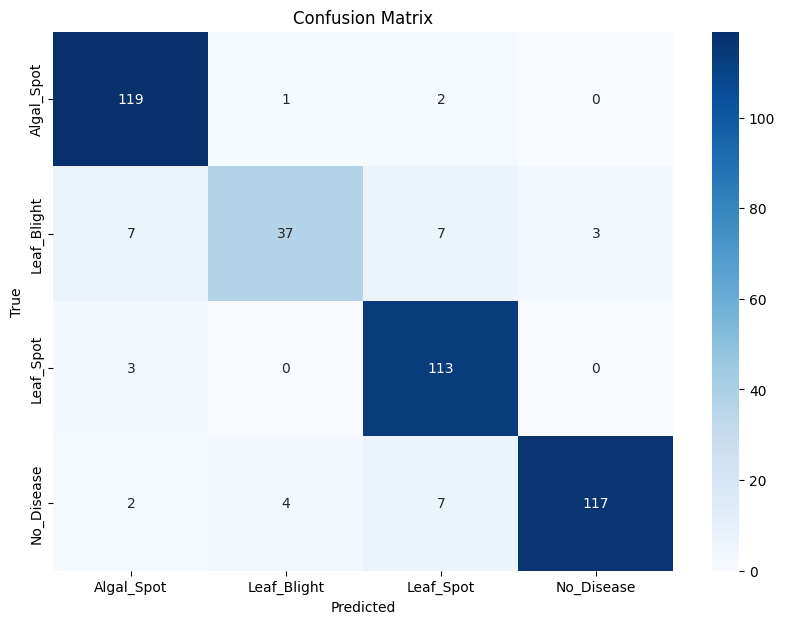

In [76]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(classes))))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Training Loss Curve
จากภาพจะสังเกตุได้ว่าทุกๆEpoch ที่เพิ่มขึ้น ค่าLossจะยิ่งเข้าใกล้ 0 มากขึ้น

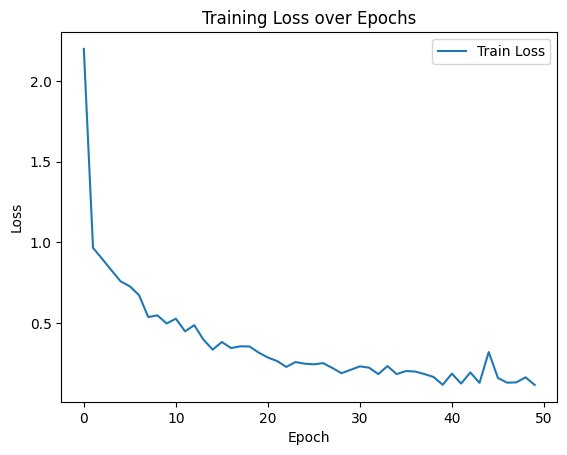

In [79]:
# End of training: Plot loss over epochs
plt.plot(train_loss_list, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4.2 Description for Evaluation
จากการเทรน Model CNN จะสามารถประเมิน Model ด้วยค่าต่างๆดังนี้
1. Accuracy Score : เป็นการประเมินจากจำนวนที่ทำการ Prediction ออกมาได้ถูกต้องจากทั้งหมด มีวิธีคำนวณคือ (TP+TN)/N ซึ่งใน Model เราจะได้ Accuracy อยู่ที่ 91.23%

---

2. Precision : เป็นการPredictionของหมวดหมู่ที่เราสนใจ เช่น ทำนาย 100 ข้อมูล ทำนายถูก 82 ตัว(TP) ทำนายข้อมูล18ตัวเป็นถูกจากที่ควรจะผิด(FP) เมื่อนำมาคิดคำนวณด้วยสูตร TP/(TP+FP) จะได้ 82.0% สรุปคือข้อมูลที่เราสนใจมีค่าอื่นนอกจากที่เราสนใจถูกทำนายมาอยู่ในสิ่งที่เราสนใจ ดังนั้นสำหรับ Precision Score ที่ได้จากการคำนวณ คือ [0.90769231 0.89473684 0.87692308 0.95967742] จะมีความหมายว่า
   - ในclass Algal Spot จะมีPrecisionอยู่ที่ 90.7692% จากการทำนายภาพชนิด Algal Spot
   - ในclass Leaf Blight จะPrecisionอยู่ที่ 89.4736% จากการทำนายภาพชนิด Leaf Blight
   - ในclass Leaf Spot จะมีPrecisionยู่ที่ 87.6923% จากการทำนายภาพชนิด Leaf Spot
   - ในclass No Disease จะมีPrecisionอยู่ที่ 95.9677% จากการทำนายภาพชนิด No Disease
---

3.  Recall : เป็นการPredictionของค่าจริงที่Predictionได้ เช่น ทำนาย 92 ข้อมูล ทำนายถูก 76 ตัว(TP) ทำนายข้อมูล 16 ตัวเป็นผิดจากที่ควรจะถูก(FN) เมื่อนำมาคิดคำนวณด้วยสูตร TP/(TP+FN) จะได้ 82.6% สรุปคือข้อมูลในกลุ่มที่เราสนใจถูกทำนายให้ไปอยู่กับclassที่เราไม่ได้สนใจ ดังนั้นสำหรับ Recall Score ที่ได้จากการคำนวณ คือ [0.96721311 0.62962963 0.98275862 0.91538462] จะมีความหมายว่า
       - ในclass Algal Spot จะมีRecallอยู่ที่ 96.7213% จากการทำนายภาพชนิด Algal Spot
       - ในclass Leaf Blight จะมีRecallอยู่ที่ 62.9629% จากการทำนายภาพชนิด Leaf Blight
       - ในclass Leaf Spot จะมีRecallอยู่ที่ 98.2758% จากการทำนายภาพชนิด Leaf Spot
       - ในclass No Disease จะมีRecallอยู่ที่ 91.5384% จากการทำนายภาพชนิด No Disease

---

4. F1 Score : เป็นการหาค่าเฉลี่ยของ Precision และ Recall ซึ่งมีสูตรในการคำนวณคือ 2 x Precision x Recall / (Precision + Recall) แต่เนื่องจากการทำ classification โดย Model มีทั้งหมด4 class และในแต่ละclass จำนวนภาพไม่เท่ากัน ทำให้การคิด F1 scoreต่อ 1 class จะคิดแบบถ่วงน้ำหนักโดยการนำจำนวนภาพในแต่ละclassที่Predictคูณเข้าไปกับ F1 score ของแต่ละclass จะได้เป็น (2 x Precision x Recall / (Precision + Recall)) x จำนวนภาพในแต่ละclass เมื่อนำF1 score ของแต่ละclass มารวมกันแล้วหารด้วยจำนวนภาพที่ทำนายทั้งหมด จะได้เป็น F1 score รวมโดยต่าที่ยิ่งสูงบ่งบอกถึงประสิทธิภาพของ Model ที่ดี ซึ่งในModel CNN มี F1 score อยู่ที่ 90.87 %

---

5. Confusion Metric : เป็นการแสดงจำนวนที่ทำนายในแต่ละ class ในรูปแบบตาราง ทำให้รู้ว่าทำนายถูกกี่ภาพในแต่ละ class ทำนายที่ทำนายผิดไปอยู่classใด


# 5.Model Improvement



## 5.1 Model error analysis
จากผลลัพธ์การ Train Model ที่เกิดขึ้นพบว่าในแต่ละ Class ยังมีการ Predict ที่ผิดพลาดอยู่มากโดยเฉพาะ Class Algal Spot และ Leaf Spot นอกจากนี้ Model CNN ยังใช้เวลาในการ Train นานมากๆ ซึ่งสาเหตุที่ทำให้ Predict พลาดเยอะอาจเกิดจากการที่มีข้อมูลในการ Train Model น้อยเกินไปในแต่ละ Class

## 5.2 Model improvement

### Model Transferlearning (Efficient Net)
การใช้ Model Transfer Learning จะช่วยลดรอบและเวลาในการ Train Model ได้มากเนื่องจาก Model Transfer Learning เป็น Model ที่ผ่านการ Train ด้วยชุดข้อมูลขนาดใหญ่มาก่อนทำให้ได้ค่าตัวเลขน้ำหนักที่สามารถนำมาเป็นจุดเริ่มต้นของการ Train Model เวลาในการ Train จึงน้อยลง และเนื่องจากปริมาณข้อมูลที่ใช้ในการ Train มีจำกัด อาจทำให้โมเดลเกิด Overfitting ได้ง่าย การใช้ Transfer Learning ช่วยลดความเสี่ยงนี้ได้


ทำไมถึงต้อง Efficient Net?

จากการหาข้อมูลพบว่าการการจำแนกโรคในพืช Transfer Learning Model ที่มีประสิทธิภาพในการแยกโรคทางใบพืชที่ดีที่สุดคือ Efficient Net จะเห็นได้ว่า Efficient Net มีความแม่นยำมากกว่า Transfer Learning ตัวอื่นๆ และใช้เวลาน้อยที่สุด (ทาง Model ใช้ Efficient Net B0 เนื่องด้วยเวลาการ Train ที่น้อยที่สุดและมีประสิทธิภาพสูงกว่า Model Transfer Learning ตัวอื่นๆที่ไม่ใช่ Efficient Net Version ที่สูงกว่า)

**Reference**
- https://openagriculturejournal.com/VOLUME/18/ELOCATOR/e18743315305194/FULLTEXT/
- https://www.semanticscholar.org/paper/Plant-leaf-disease-classification-using-deep-model-Atila-U%C3%A7ar/7a96cf43dc8b99e4da527ec645931a0033effc67
- https://www.sciencedirect.com/science/article/pii/S1574954120301321?casa_token=382NVKnOwRMAAAAA:dNrhoiSe7D8gq39fO5iKrhmPbSRjzPv5lVrf5S-jJPBTV28BXgdArFGq8PudrEhPjPJfinvTLA


In [101]:
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        # Replace the classifier to match the number of classes
        in_features = self.model.classifier[1].in_features  # Get the input features of the classifier layer
        self.model.classifier[1] = nn.Linear(in_features, num_classes)  # Update to match num_classes

    def forward(self, x):
        return self.model(x)

In [105]:
from tqdm.auto import tqdm

num_classes = len(classes)  # Adjust based on your dataset
model_Transfer_Learning = TransferLearningModel(num_classes=num_classes)

# Hyperparameters
learning_rate = 0.001
num_epochs = 5

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_Transfer_Learning.parameters(), lr=learning_rate)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_Transfer_Learning.to(device)

train_loss_list_Transfer_Learning = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    model_Transfer_Learning.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_Transfer_Learning(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_data)
    epoch_accuracy = correct_preds / total_preds
    train_loss_list_Transfer_Learning.append(epoch_loss)
    

    # Evaluation
    model_Transfer_Learning.eval()
    all_labels = []
    all_preds = []

    with torch.inference_mode():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_Transfer_Learning(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    print(f'F1 Score (Weighted): {f1:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')

 20%|████████▊                                   | 1/5 [05:39<22:37, 339.33s/it]

Epoch 1/5, Loss: 0.4770, Accuracy: 0.8469
F1 Score (Weighted): 0.9271
Test Accuracy: 0.9265


 40%|█████████████████▌                          | 2/5 [21:39<35:13, 704.42s/it]

Epoch 2/5, Loss: 0.2317, Accuracy: 0.9235
F1 Score (Weighted): 0.9430
Test Accuracy: 0.9431


 60%|██████████████████████████▍                 | 3/5 [38:36<28:14, 847.02s/it]

Epoch 3/5, Loss: 0.1191, Accuracy: 0.9612
F1 Score (Weighted): 0.9762
Test Accuracy: 0.9763


 80%|███████████████████████████████████▏        | 4/5 [44:13<10:45, 645.74s/it]

Epoch 4/5, Loss: 0.1289, Accuracy: 0.9612
F1 Score (Weighted): 0.9621
Test Accuracy: 0.9621


100%|████████████████████████████████████████████| 5/5 [49:49<00:00, 597.82s/it]

Epoch 5/5, Loss: 0.1092, Accuracy: 0.9704
F1 Score (Weighted): 0.9811
Test Accuracy: 0.9810


## 5.3 Result After Improvement

In [107]:
# Evaluation
model_Transfer_Learning.eval()
all_labels = []
all_preds = []

with torch.inference_mode():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_Transfer_Learning(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

### Accuracy

In [108]:
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9810


### Precision

In [109]:
precision = precision_score(np.array(all_labels).astype(int),np.array(all_preds).astype(int),average=None)
print(f'Precision: {precision}')

Precision: [0.95275591 0.98181818 1.         0.99224806]


### Recall

In [110]:
recall = recall_score(np.array(all_labels).astype(int),np.array(all_preds).astype(int),average=None)
print(f'Recall: {recall}')

Recall: [0.99180328 1.         0.95689655 0.98461538]


### F1 Score

In [111]:
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'F1 Score (Weighted): {f1:.4f}')

F1 Score (Weighted): 0.9811


### Confusion Metric

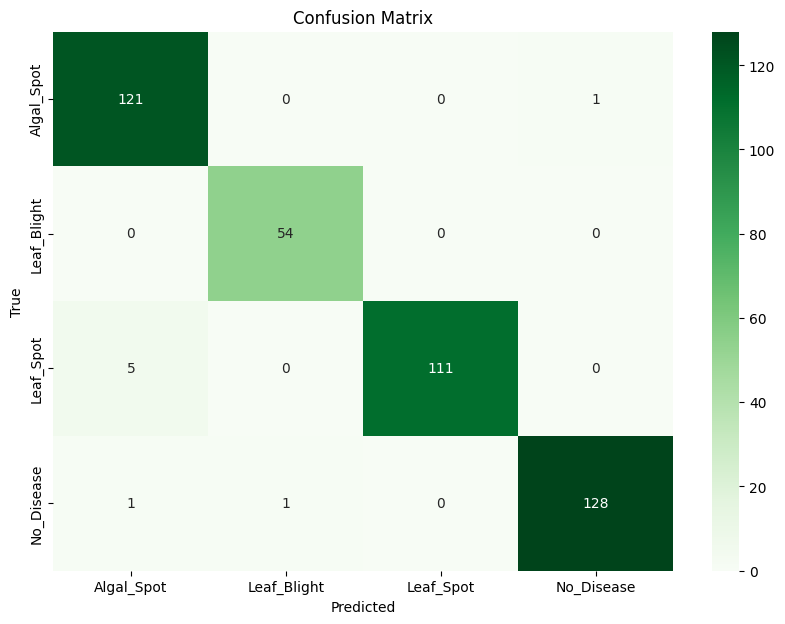

In [153]:
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(classes))))
    
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Training Loss Curve

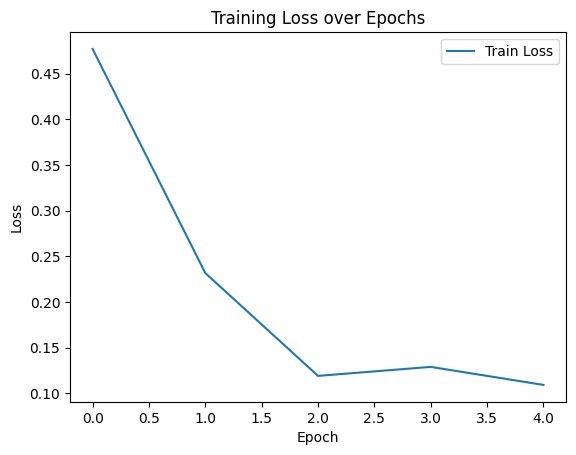

In [141]:
# End of training: Plot loss over epochs
plt.plot(train_loss_list_Transfer_Learning, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<span style="font-size: 24px;">จากผลลัพธ์จะเห็นได้ว่า Accuracy, Precision, Recall, No Disease เพิ่มขึ้นอย่างเห็นได้ชัด เมื่อทำการ Train ด้วย Pretrain Model อย่าง Efficient Net</span>

<h2>Accuracy</h2>
<table style="font-size: 20px; text-align: left; border-collapse: collapse; width: 100%;">
  <tr>
    <th style="border: 1px solid black;">Accuracy</th>
    <th style="border: 1px solid black;">Before</th>
    <th style="border: 1px solid black;">After</th>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Value</td>
    <td style="border: 1px solid black;">91.23%</td>
    <td style="border: 1px solid black;">98.10%</td>
  </tr>
</table>

<br>

<h2>Precision</h2>
<table style="font-size: 20px; text-align: left; border-collapse: collapse; width: 100%;">
  <tr>
    <th style="border: 1px solid black;">Precision</th>
    <th style="border: 1px solid black;">Algal Spot</th>
    <th style="border: 1px solid black;">Leaf Blight</th>
    <th style="border: 1px solid black;">Leaf Spot</th>
    <th style="border: 1px solid black;">No Disease</th>
  </tr>
  <tr>
    <th style="border: 1px solid black;">Before</th>
    <td style="border: 1px solid black;">90.76%</td>
    <td style="border: 1px solid black;">89.47%</td>
    <td style="border: 1px solid black;">87.69%</td>
    <td style="border: 1px solid black;">95.96%</td>
  </tr>
  <tr>
    <th style="border: 1px solid black;">After</th>
    <td style="border: 1px solid black;">95.27%</td>
    <td style="border: 1px solid black;">98.18%</td>
    <td style="border: 1px solid black;">100.00%</td>
    <td style="border: 1px solid black;">99.22%</td>
  </tr>
</table>

<br>

<h2>Recall</h2>
<table style="font-size: 20px; text-align: left; border-collapse: collapse; width: 100%;">
  <tr>
    <th style="border: 1px solid black;">Recall</th>
    <th style="border: 1px solid black;">Algal Spot</th>
    <th style="border: 1px solid black;">Leaf Blight</th>
    <th style="border: 1px solid black;">Leaf Spot</th>
    <th style="border: 1px solid black;">No Disease</th>
  </tr>
  <tr>
    <th style="border: 1px solid black;">Before</th>
    <td style="border: 1px solid black;">96.72%</td>
    <td style="border: 1px solid black;">62.96%</td>
    <td style="border: 1px solid black;">98.27%</td>
    <td style="border: 1px solid black;">91.53%</td>
  </tr>
  <tr>
    <th style="border: 1px solid black;">After</th>
    <td style="border: 1px solid black;">99.18%</td>
    <td style="border: 1px solid black;">100.00%</td>
    <td style="border: 1px solid black;">95.68%</td>
    <td style="border: 1px solid black;">98.46%</td>
  </tr>
</table>

<br>

<h2>F1 Score</h2>
<table style="font-size: 20px; text-align: left; border-collapse: collapse; width: 100%;">
  <tr>
    <th style="border: 1px solid black;">F1 Score</th>
    <th style="border: 1px solid black;">Before</th>
    <th style="border: 1px solid black;">After</th>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Value</td>
    <td style="border: 1px solid black;">90.87%</td>
    <td style="border: 1px solid black;">98.11%</td>
  </tr>
</table>


# 6. Others
จากการ Train Model ข้างต้นที่สามารถทำนายโรคในทุเรียนได้แม่นยำมากขึ้น แต่ก็อาจมีรูปภาพบางส่วนที่ไม่ใช่ใบทุเรียนเมื่อนำไปทำนายแล้วยังมีค่าความน่าจะเป็นของตัวเลขในแต่ละ Class ที่สูง พวกเราจึงได้พัฒนา Model มาอีกตัวที่สามารถทำนายได้ว่าใบไม้ใบนี้เป็นใบทุเรียนหรือไม่

## 6.1 Manage the data
ทำการสร้าง Dataset อีกชุดซึ่งประกอบไปด้วย 2 Class คือ Durian leaf และ Non Durian Leaf ในส่วนของข้อมูลภาพ Durian Leaf เราจะใช้ข้อมูลภาพใบทุเรียนที่เก็บมาทั้งหมดจำนวน 1845 รูป และในส่วนของ Non Durian Leaf เราจะทำการหาภาพของวัตถุอื่นๆมาใช้เป็นdatasetโดยรูปที่นำมาใช้จะมีทั้งหมด 17 ประเภทดังนี้ อาคาร,หนังสือ,เสื้อผ้า,จักรยาน,เฟอร์นิเจอร์,อาหาร,รองเท้า,รถยนตร์,สัตว์,ต้นไม้,มนุษย์,ดอกไม้,อุปกรณ์กีฬา,เครื่องมือ,เครื่องดนตรี,ของเล่น,คอมพิวเตอร์ ประเภทละ 100 รูป ซึ่งรูปเหล่านี้สามารถใช้ library อย่าง Beautiful soup เพื่อ Download ภาพตามประเภทที่กำหนดไว้ได้


### Create folder train,test for contain the Durian leaf and Non Durian Leaf

In [118]:
# Setup path to data folder
data_path = Path("data2/")
train_path = data_path / "train" / "durian_leaf"
test_path = data_path / "test" / "durian_leaf"

# If the image folder doesn't exist, download it and prepare it...
if train_path.is_dir():
    print(f"{train_path} directory exists.")
else:
    print(f"Did not find {train_path} directory, creating one...")
    train_path.mkdir(parents=True, exist_ok=True)

if test_path.is_dir():
    print(f"{test_path} directory exists.")
else:
    print(f"Did not find {test_path} directory, creating one...")
    test_path.mkdir(parents=True, exist_ok=True)

Did not find data2/train/durian_leaf directory, creating one...
Did not find data2/test/durian_leaf directory, creating one...


### Spilt the data for Durian Leaf class
แบ่งข้อมูล Train:Test -> 70:30

In [121]:
import shutil
from sklearn.model_selection import train_test_split
import os

# Define source and destination directories
source_dir = '/Users/nut/Documents/AiDurian/dataset_durian'
train_dir = '/Users/nut/Documents/AiDurian/data2/train/durian_leaf'
test_dir = '/Users/nut/Documents/AiDurian/data2/test/durian_leaf'

# Create the train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all class folders
class_folders = os.listdir(source_dir)

# Loop through each class folder
for class_folder in class_folders:
    class_path = os.path.join(source_dir, class_folder)

    # Ensure it is a directory
    if os.path.isdir(class_path):
        # List all files in the current class folder
        files = os.listdir(class_path)

        # Split the files into training and testing sets (70% train, 30% test)
        train_files, test_files = train_test_split(files, test_size=0.3, random_state=42)

        # Move or copy training files into the common train directory
        for file in train_files:
            src_file = os.path.join(class_path, file)
            dest_file = os.path.join(train_dir, file)  # No class subdirectories
            shutil.copy(src_file, dest_file)  # Use shutil.move() to move instead of copy

        # Move or copy testing files into the common test directory
        for file in test_files:
            src_file = os.path.join(class_path, file)
            dest_file = os.path.join(test_dir, file)  # No class subdirectories
            shutil.copy(src_file, dest_file)  # Use shutil.move() to move instead of copy

print("Files successfully split into train and test sets.")


Files successfully split into train and test sets.


In [123]:
class_train  = os.path.join(train_dir)
images_leafs_train = os.listdir(class_train)
print(f"There are {len(images_leafs_train)} images in {class_train}")

There are 1289 images in /Users/nut/Documents/AiDurian/data2/train/durian_leaf


In [124]:
class_test  = os.path.join(test_dir)
images_leafs_test = os.listdir(class_test)
print(f"There are {len(images_leafs_test)} images in {class_test}")

There are 556 images in /Users/nut/Documents/AiDurian/data2/test/durian_leaf


### Downloading Non Durian Leaf Data by BeautifulSoup

In [131]:
categories = [
    "buildings", "books", "clothes", "food","bikes","furniture", "shoes","cars", "animals", "trees", "humans",
     "flowers","Sports equipment", "Tools", "Musical instruments","Toys", "computers"
]

# Create directories for train, valid, and test splits
base_dir = data_path
for split in ['train', 'test']:
    os.makedirs(os.path.join(base_dir, split, 'non_durian_leaf'), exist_ok=True)

# Function to download images from Bing
def download_bing_images(search_term, required_num_images, output_dir):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }

    downloaded_images = 0

    while downloaded_images < required_num_images:
        search_url = f"https://www.bing.com/images/search?q={search_term}&form=HDRSC2&first={downloaded_images+1}&scenario=ImageBasicHover"

        response = requests.get(search_url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find image elements
        img_elements = soup.find_all('img', class_='mimg')
        img_urls = [img['src'] for img in img_elements if 'src' in img.attrs]

        # Ensure we only download the remaining number of required images
        img_urls = img_urls[:required_num_images - downloaded_images]

        for i, url in enumerate(img_urls):
            try:
                img_data = requests.get(url).content
                with open(os.path.join(output_dir, f'{search_term}_{downloaded_images + i}.jpg'), 'wb') as handler:
                    handler.write(img_data)
                downloaded_images += 1
                print(f"Downloaded {search_term}_{downloaded_images}.jpg")
            except Exception as e:
                print(f'Could not download {url}: {e}')

        time.sleep(2)  # Sleep for 2 seconds to avoid getting blocked

# Download images for each category and organize them into a specific directory
required_images_per_category = 100  # Adjust as needed for your total dataset size

for category in categories:
    category_dir = os.path.join("negative_samples", category)
    os.makedirs(category_dir, exist_ok=True)

    # Download images for the current category
    download_bing_images(category, required_images_per_category, category_dir)

    # Sleep to avoid overwhelming the server
    time.sleep(3)  # Sleep for 3 seconds between categories


Downloaded flowers_1.jpg
Downloaded flowers_2.jpg
Downloaded flowers_3.jpg
Downloaded flowers_4.jpg
Downloaded flowers_5.jpg
Downloaded flowers_6.jpg
Downloaded flowers_7.jpg
Downloaded flowers_8.jpg
Downloaded flowers_9.jpg
Downloaded flowers_10.jpg
Downloaded flowers_11.jpg
Downloaded flowers_12.jpg
Downloaded flowers_13.jpg
Downloaded flowers_14.jpg
Downloaded flowers_15.jpg
Downloaded flowers_16.jpg
Downloaded flowers_17.jpg
Downloaded flowers_18.jpg
Downloaded flowers_19.jpg
Downloaded flowers_20.jpg
Downloaded flowers_21.jpg
Downloaded flowers_22.jpg
Downloaded flowers_23.jpg
Downloaded flowers_24.jpg
Downloaded flowers_25.jpg
Downloaded flowers_26.jpg
Downloaded flowers_27.jpg
Could not download data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAEALAAAAAABAAEAAAIBTAA7: No connection adapters were found for 'data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAEALAAAAAABAAEAAAIBTAA7'
Downloaded flowers_28.jpg
Downloaded flowers_29.jpg
Downloaded flowers_30.jpg
Downloaded 

### Split the data for non durian leaf to train:test -> 70:30 

In [135]:
# Function to split dataset into train/test (70% train, 30% test)
def split_dataset(folder, train_size=0.7, test_size=0.3):
    all_images = os.listdir(folder)

    # Split images into train (70%) and test (30%)
    train, test = train_test_split(all_images, test_size=test_size, random_state=42)

    return train, test

# Split images for each category
for category in categories:
    category_path = os.path.join("negative_samples", category)
    if os.path.exists(category_path):
        # Split images into train and test
        train, test = split_dataset(category_path)

        # Move images to the respective directories
        for split, images in zip(['train', 'test'], [train, test]):
            for img in images:
                src = os.path.join(category_path, img)
                dst = os.path.join(base_dir, split, 'non_durian_leaf', img)
                shutil.move(src, dst)

print("Images successfully split and moved into train and test directories.")

Images successfully split and moved into train and test directories.


### Data Tranforming
การทำ Data Transforming จะมีลักษณะในการทำที่เหมือนกับ Trasnsforming Model แรกแต่เนื่องจากภาพที่ใช้ Train ไม่เหมือนกับ Model แรก ทำให้ต้องมีการคำนวณค่า Mean และ Std ใหม่เพื่้อใช้ในการ Normalize รูปของ Model ที่ 2 โดยเฉพาะ

In [136]:
#การคำนวณค่าNormalization
# Step 1: Calculate mean and standard deviation
initial_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root="/Users/nut/Documents/AiDurian/data2/train", transform=initial_transform)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

# Initialize mean and std
mean2 = 0.0
std2 = 0.0
total_images2 = 0

# Calculate mean and std for training data
for images, _ in train_dataloader:
    batch_samples = images.size(0)  # Number of images in the batch
    images = images.view(batch_samples, images.size(1), -1)  # Reshape to (batch, channels, -1)
    mean2 += images.mean(2).sum(0)  # Sum over all pixels in the batch
    std2 += images.std(2).sum(0)  # Sum over all pixels in the batch
    total_images2 += batch_samples

mean2 /= total_images2  # Final mean
std2 /= total_images2  # Final std

print(f"Calculated Mean: {mean2}")
print(f"Calculated Std: {std2}")

Calculated Mean: tensor([0.5384, 0.5618, 0.4513])
Calculated Std: tensor([0.2105, 0.2051, 0.2096])


In [137]:
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.Resize((224, 224)),
    transforms.CenterCrop((180,120)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean2[0].item(), mean2[1].item(), mean2[2].item()),
                         std=(std2[0].item(), std2[1].item(), std2[2].item()))
])

### Loading image to Dataset
นำข้อมูลที่แยกเป็น Folder แล้วมาทำเป็น Dataset

In [138]:
train_data = datasets.ImageFolder(root=data_path / "train",
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=data_path / "test",
                                 transform=data_transform,
                                 target_transform=None)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2400
    Root location: data2/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(180, 120))
               ToTensor()
               Normalize(mean=(0.538438618183136, 0.5618433952331543, 0.4512849450111389), std=(0.21048930287361145, 0.20507113635540009, 0.20963750779628754))
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1045
    Root location: data2/test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(22

### Turn Data into Dataloader
แปลง Dataset เป็น DataLoader เพื่อแบ่งรอบข้อมูลภาพที่นำเอาเข้าไป Train

In [139]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

print(f"train_dataloader:{len(train_dataloader)},test_dataloader:{len(test_dataloader)}")
print(f"train_data:{len(train_data)},test_data:{len(test_data)}")

train_dataloader:75,test_dataloader:33
train_data:2400,test_data:1045


## 6.2 Train Model

### Model Transfer Learning (Efficient Net)
เป็น Model แบบเดียวกับที่ใช้ Train Model วิเคราะห์โรคทางใบทุเรียน มีข้อแตกต่างตรงที่ Output layer ของ Model จะออะมาแค่ 1 Unit ซึ่ง Unit นี้จะทำการส่งค่าที่ทำนายออกมาในรูปแบบLogit(ค่าตัวเลขดิบ) และวิธีการที่จะทำให้ทราบถึงความน่าจะเป็นที่ถูกPredictออกมาคือการใช้  Sigmoid Function และข้อแตกต่างอีกข้อคือ Loss Function ที่ใช้ในการ Train Model คือ Binary Cross Entripy Loss เป็นการคำนวณ Loss Function ที่เหมาะกับการทำ Binary Classification 

In [140]:
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        # Replace the classifier to match the number of classes
        in_features = self.model.classifier[1].in_features  # Get the input features of the classifier layer
        self.model.classifier[1] = nn.Linear(in_features, num_classes)  # Update to match num_classes

    def forward(self, x):
        return self.model(x)

In [143]:
# Initialize model
model_Binary = TransferLearningModel(num_classes=1)

# Hyperparameters
learning_rate = 0.01
num_epochs = 5

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_Binary.to(device)

# Initialize loss function and optimizer for binary classification
criterion = nn.BCEWithLogitsLoss()  # Use this for binary classification
optimizer = torch.optim.Adam(model_Binary.parameters(), lr=learning_rate)
train_loss_list_Binary=[]

# Training loop
for epoch in tqdm(range(num_epochs)):
    model_Binary.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_Binary(images)
        loss = criterion(outputs.squeeze(), labels.float())  # Squeeze outputs for correct shape

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to predictions
        total_preds += labels.size(0)
        correct_preds += (predicted.squeeze() == labels).sum().item()

    epoch_loss = running_loss / len(train_data)
    epoch_accuracy = correct_preds / total_preds
    train_loss_list_Binary.append(epoch_loss)

    # Evaluation
    model_Binary.eval()
    all_labels_Binary = []
    all_preds_Binary = []

    with torch.inference_mode():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_Binary(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to predictions
            all_labels_Binary.extend(labels.cpu().numpy())
            all_preds_Binary.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels_Binary, all_preds_Binary)
    f1 = f1_score(all_labels_Binary, all_preds_Binary, average='weighted')
    cm = confusion_matrix(all_labels_Binary, all_preds_Binary)
    
    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    print(f'F1 Score (Weighted): {f1:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')

 20%|████████▊                                   | 1/5 [12:31<50:05, 751.28s/it]

Epoch 1/5, Loss: 0.1953, Accuracy: 0.9379
F1 Score (Weighted): 0.9923
Test Accuracy: 0.9923


 40%|████████████████▍                        | 2/5 [38:28<1:01:15, 1225.12s/it]

Epoch 2/5, Loss: 0.0930, Accuracy: 0.9704
F1 Score (Weighted): 0.9866
Test Accuracy: 0.9866


 60%|█████████████████████████▊                 | 3/5 [51:18<33:54, 1017.49s/it]

Epoch 3/5, Loss: 0.0512, Accuracy: 0.9846
F1 Score (Weighted): 0.9885
Test Accuracy: 0.9885


 80%|█████████████████████████████████▌        | 4/5 [1:03:21<15:01, 901.04s/it]

Epoch 4/5, Loss: 0.0794, Accuracy: 0.9688
F1 Score (Weighted): 0.9384
Test Accuracy: 0.9388


100%|██████████████████████████████████████████| 5/5 [1:15:31<00:00, 906.34s/it]

Epoch 5/5, Loss: 0.0708, Accuracy: 0.9754
F1 Score (Weighted): 0.9952
Test Accuracy: 0.9952


## 6.4 Test Model

In [146]:
model_Binary.eval()
all_labels_Binary = []
all_preds_Binary = []

with torch.inference_mode():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_Binary(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to predictions
        all_labels_Binary.extend(labels.cpu().numpy())
        all_preds_Binary.extend(predicted.cpu().numpy())

### Evaluation Model


#### Accuracy

In [148]:
accuracy = accuracy_score(all_labels_Binary, all_preds_Binary)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9962


#### Precision

In [147]:
precision = precision_score(np.array(all_labels_Binary).astype(int),np.array(all_preds_Binary).astype(int),average=None)
print(f'Precision: {precision}')

Precision: [0.99640288 0.99591002]


#### Recall

In [149]:
recall = recall_score(np.array(all_labels_Binary).astype(int),np.array(all_preds_Binary).astype(int),average=None)
print(f'Recall: {recall}')

Recall: [0.99640288 0.99591002]


#### F1 Score

In [150]:
f1 = f1_score(all_labels_Binary, all_preds_Binary, average='weighted')
print(f'F1 Score (Weighted): {f1:.4f}')

F1 Score (Weighted): 0.9962


#### Confusion Metric

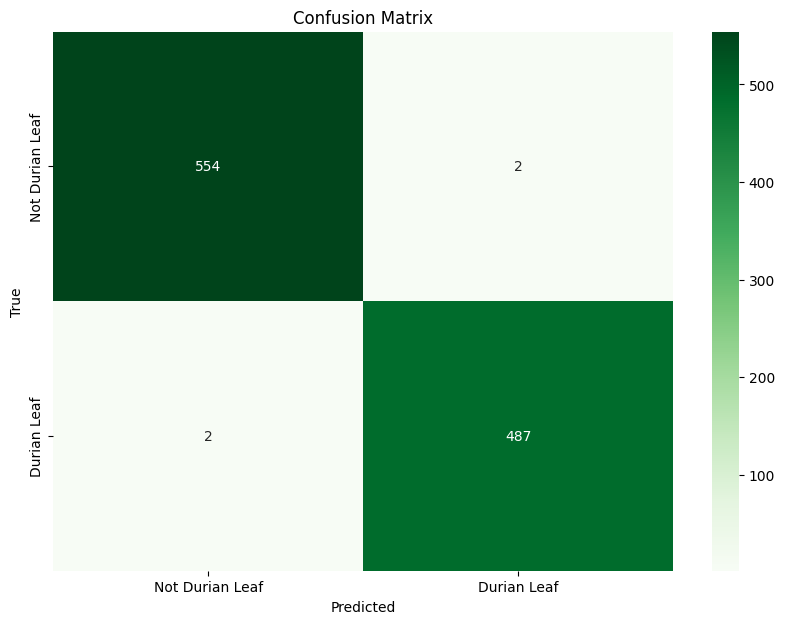

In [159]:
cm = confusion_matrix(all_labels_Binary, all_preds_Binary, labels=[0,1])
    
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["Not Durian Leaf", "Durian Leaf"], yticklabels=["Not Durian Leaf", "Durian Leaf"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Training Loss curve

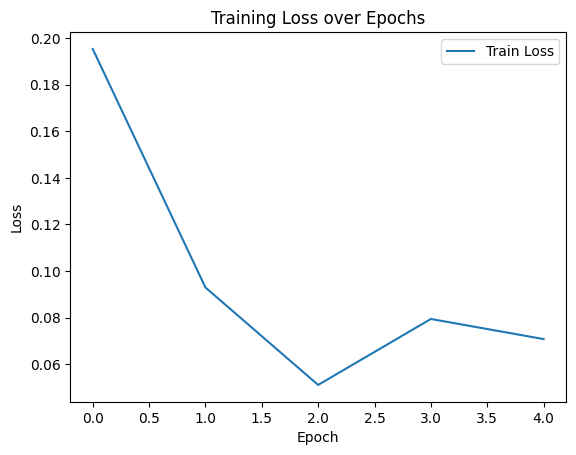

In [160]:
# End of training: Plot loss over epochs
plt.plot(train_loss_list_Binary, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
__plt.show()

#### Summary model 2
จากผลลัพธ์ข้างต้นจะเห็นได้ว่าการ Train Model ตัวที่ 2 ที่มีการใช้ Model Transfer Learning เหมือนการ Prediction โรคในใบทุเรียน จะมีค่า Loss ที่ต่ำตั้งแต่รอบการเทรนแรกๆนั่นแสดงให้เห็นว่าการ Train Model ว่าเป็นใบทุเรียนหรือไม่อาจไม่ได้มีความซับซ้อนเท่ากับโรคที่อยู่ในใบทุเรียน นอกจากนี้หลังจากการประเมิน Model ด้วยฟังค์ชั่นต่างๆจะเห็นได้ว่าค่าความน่าจะเป็นต่างๆมีค่าที่สูงมาก